The purpose of this notebook is to perform what was done earlier but then take the derivative of $\lambda$ wrt the inputs to get the PDF of $\lambda$. This should resemble the $\chi^2$ distribution.

In [1]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
from joblib import  Memory

import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

In [2]:
FONTSIZE=18
font = {'family': 'serif', 'weight':'normal', 'size':FONTSIZE}
mp.rc('font', **font)
mp.rc('text',usetex=True)

In [3]:
def debug(func):
    """Print the function signature and return value"""
    import functools

    @functools.wraps(func)
    def wrapper_debug(*args, **kwargs):
        args_repr = [repr(a) for a in args]
        kwargs_repr = [f"{k}={v!r}" for k, v in kwargs.items()]
        signature = ", ".join(args_repr + kwargs_repr)
        print(f"Calling {func.__name__}({signature})")
        values = func(*args, **kwargs)
        print(f"{func.__name__!r} returned {values!r}")
        return values

    return wrapper_debug

def theta_hat_func(n,m, MLE):
       #n,m are integer arrays
    if MLE==True:
        theta_hat = n-m
    else:
        # non-MLE
        # theta_hat = n-m
        # theta_hat = (theta_hat) * (theta_hat > 0)
        theta_hat = np.where(n>m, n-m, 0)
         
    return theta_hat


def L_prof_global(n,m, MLE):
    #n,m integer arrays
    # nu_hat = m, if theta_hat = theta_hat_MLE
    # nu_hat  =  (m+n)/2 if theta_hat = n-m
    # nu_hat = 0  if theta_hat != n-m
    theta_hat=theta_hat_func(n,m,MLE)
    # print('n-m ',  n-m)
    if MLE==True:
        # i.e. if theta_hat = n-m
        # assert theta_hat==n-m
        nu_hat = m
    else:
        nu_hat = np.where(theta_hat ==0, (m+n)/2, m)
        # if theta_hat==0:
        #     nu_hat =(m+n)/2
        # else:
        #     _hat = m
        # # if theta_hat== n-m:
        # #     nu_hat = (m+n)/2
        # # else:
        # #     nu_hat = 0
        # # nu_hat = np.where(theta_hat==n-m,
        # #                   (m+n)/2, 
        # #                   0)
    p1=st.poisson.pmf(n, theta_hat+nu_hat)
    p2 = st.poisson.pmf(m, nu_hat)
    return p1*p2

def L_theta_nu(n,m,theta,nu):
    p1 = st.poisson.pmf(n, theta+nu)
    p2 = st.poisson.pmf(m, nu)
    return p1*p2
def lambda_test_2d(n,m, theta, nu, MLE):
    Ln= L_theta_nu(n,m,theta,nu)
    
    Ld= L_prof_global(n,m, MLE)
    eps=1e-20
    Ld=Ld+eps
    lambda_  = -2*np.log(Ln/Ld)
    return np.array(lambda_)

In [4]:
def D(Nmin, Nmax, Mmin, Mmax):
    return [(n,m) for N in range(Nmin, Nmax) for m in range(Mmin, Mmax)]


In [5]:
def save_model(model, PARAMS, pth_string):
    """pth string is the name of the pth file which is a dictionary of dictionaries"""
    models_path = os.path.join(os.getcwd(), '../models')
    PATH=os.path.join(models_path, pth_string)
    print(f'saving model with th string : {pth_string}\n')
    torch.save({'PARAMS': PARAMS,
                'model_state_dict': model.state_dict()},
                PATH)
    print(model)

In [6]:
def make_binned_X(X_min, X_max, Nbins):
    X_step = (X_max-X_min) / Nbins
    bins = np.arange(X_min, X_max+X_step, X_step)
    bin_centers = (bins[1:] + bins[:-1])/2
    return np.array(bin_centers)

def make_eval_data_2d_with_NM(Bprime, N, M, nbins_theta, nbins_nu):
    """Make evaluation data composed of: binned theta and nu, and discrete N and M,
    and optionally theta_hat. The theta hat argument accpts an MLE boolean, therefore
    if trained on MLE data, the theta_hat that we use for evaluation is just 
    n-m, including negative values.
    The return value of this function is used as the "eval_data" tensor below
    
    with lambda_D or with NM"""
    #if MLE true, load the model that was trained on MLE data and vice versa
    # N, M = D
    # nbins=NBINS
    # thetamin,thetamax=0,20
    train_df = load_2d_train_df(MLE=True, with_lambda_D=True)
    
    THETA_bin_centers = make_binned_X(X_min=train_df['theta'].min(),
                                      X_max=train_df['theta'].max(), 
                                      Nbins=nbins_theta)
        
    NU_bin_centers = make_binned_X(X_min=train_df['nu'].min(),
                                  X_max=train_df['nu'].max(), 
                                  Nbins=nbins_nu)
        
    # tensor = torch.Tensor([
                           # [x, y, theta_hat(N, M, MLE=True), N, M] 
                           # for (x,y) in zip(THETA_bin_centers,NU_bin_centers)
                          # ])

    tensor = torch.Tensor([
                       [x, y, theta_hat(N, M, MLE=True), N, M] 
                       for x in THETA_bin_centers for y in NU_bin_centers
                      ])

    #zip only traverses the lists monotonically, so experiment to use cross to take every combination of the two lists
    
    return tensor, THETA_bin_centers.ravel(), NU_bin_centers.ravel()

In [7]:
class SiLURegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.SiLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                layers.append(nn.SiLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

In [8]:
@debug
def load_untrained_model(PARAMS):
    """Load an untrained model (with weights initiatted) according to model paramateters in the 
    PARAMS dictionary

    Args:
        PARAMS (dict): dictionary of model/training parameters: i.e. hyperparameters and training parameters.

    Returns:
        utils.RegularizedRegressionModel object
    """
    model = SiLURegressionModel(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"],
        # activation=PARAMS["activation"]
    )
    # model.apply(initialize_weights)
    print('INITIATED UNTRAINED MODEL:',
          # model
         )
    # print(model)
    return model
    

# Step 1: define model parameters for MLE=False model

In [9]:
PARAMS_lambdaD_nonMLE_SILU = {
"n_layers": int(12),
"hidden_size": int(12),
"dropout": float(0.13),
"NFEATURES":int(3),
"activation": "SiLU",
'optimizer_name':'NAdam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.0006),
'momentum':float(0.9),
'batch_size':int(256*2),
'n_iterations': int(1e5),
'traces_step':int(100),
'L2':float(0.1),
'MLE':False,
'with_lambda_D':True,
'pth_string':'FEB_20_model_lambda_D_nonMLE_SILU.pth'
}

# step 2: load untrained model for MLE=False

In [10]:
untrained_SiLU_model_nonMLE = load_untrained_model(PARAMS_lambdaD_nonMLE_SILU)

Calling load_untrained_model({'n_layers': 12, 'hidden_size': 12, 'dropout': 0.13, 'NFEATURES': 3, 'activation': 'SiLU', 'optimizer_name': 'NAdam', 'starting_learning_rate': 0.0006, 'momentum': 0.9, 'batch_size': 512, 'n_iterations': 100000, 'traces_step': 100, 'L2': 0.1, 'MLE': False, 'with_lambda_D': True, 'pth_string': 'FEB_20_model_lambda_D_nonMLE_SILU.pth'})
INITIATED UNTRAINED MODEL:
'load_untrained_model' returned SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (1

# Step 3: Load Trained model for MLE=False

In [11]:
def load_model(model, PARAMS, pth_string):
    models_path = os.path.join(os.getcwd(), '../models')
    PATH=os.path.join(models_path, pth_string)
    model = SiLURegressionModel(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"]
    )
    checkpoint = torch.load(PATH)
    print('INITIATED MODEL:',  model)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'loading model with th string : {pth_string}\n')    
    print(model)
    
    return model

In [12]:
# untrained_SiLU_model = load_untrained_model(PARAMS_lambdaD_nonMLE_SILU)

trained_SiLU_model_nonMLE = load_model(model = untrained_SiLU_model_nonMLE, 
                                PARAMS=PARAMS_lambdaD_nonMLE_SILU,
                   pth_string=PARAMS_lambdaD_nonMLE_SILU["pth_string"])

INITIATED MODEL: SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (13): Dropout(p=0.13, inplace=False)
    (14): SiLU()
    (15): Linear(in_features=12, out_features=12, bias=True)
    (16): Dropout(p=0.13, inplace=False)
    (17): SiLU()
    (18): Linear(in_features=12, out_features=12, bias=True)
    (19): Dropout(p=0.13, inplace=False)
    (20): SiLU()
    (21): Linear(in_features=12, out_features=12, bias=True)
    (22): Dropout(p=0.13, inplace=False)
    (23): SiLU(

# Step 4: define model parameters for MLE=True model

In [13]:
PARAMS_lambdaD_MLE_SILU = {
"n_layers": int(12),
"hidden_size": int(12),
"dropout": float(0.13),
"NFEATURES":int(3),
"activation": "SiLU",
'optimizer_name':'NAdam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.0006),
'momentum':float(0.9),
'batch_size':int(256*2),
'n_iterations': int(6e4),
'traces_step':int(100),
'L2':float(0.1),
'MLE':True,
'with_lambda_D':True,
'pth_string':'FEB_20_model_lambda_D_MLE_SILU.pth'
}

# step 5: load untrained model for MLE=True

In [14]:
untrained_SiLU_model_MLE = load_untrained_model(PARAMS_lambdaD_MLE_SILU)

Calling load_untrained_model({'n_layers': 12, 'hidden_size': 12, 'dropout': 0.13, 'NFEATURES': 3, 'activation': 'SiLU', 'optimizer_name': 'NAdam', 'starting_learning_rate': 0.0006, 'momentum': 0.9, 'batch_size': 512, 'n_iterations': 60000, 'traces_step': 100, 'L2': 0.1, 'MLE': True, 'with_lambda_D': True, 'pth_string': 'FEB_20_model_lambda_D_MLE_SILU.pth'})
INITIATED UNTRAINED MODEL:
'load_untrained_model' returned SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (13): D

# Step 6: Load Trained model for MLE=True

In [15]:
# untrained_SiLU_model = load_untrained_model(PARAMS_lambdaD_nonMLE_SILU)

trained_SiLU_model_MLE = load_model(model = untrained_SiLU_model_MLE, 
                                PARAMS=PARAMS_lambdaD_MLE_SILU,
                   pth_string=PARAMS_lambdaD_MLE_SILU["pth_string"])

INITIATED MODEL: SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (13): Dropout(p=0.13, inplace=False)
    (14): SiLU()
    (15): Linear(in_features=12, out_features=12, bias=True)
    (16): Dropout(p=0.13, inplace=False)
    (17): SiLU()
    (18): Linear(in_features=12, out_features=12, bias=True)
    (19): Dropout(p=0.13, inplace=False)
    (20): SiLU()
    (21): Linear(in_features=12, out_features=12, bias=True)
    (22): Dropout(p=0.13, inplace=False)
    (23): SiLU(

# Summary: We have loaded `trained_SiLU_model_nonMLE` and `trained_SiLU_model_MLE`

-----------------------------------

In [248]:
class TrainedModel:
    def __init__(self, model):
        self.model = model

    def __cdf(self, x):
        # convert to a tensor and compute
 
        X = torch.Tensor(x)#.transpose(1, 0)
            
        X.requires_grad_(True)
        
        self.model.eval() 
        
        return self.model(X), X 
        
    def cdf(self, x): 
        F, _ = self.__cdf(x)
        
        Y = F.view(-1).detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y

        
        Y = F.view(-1).detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y
    
    def numerical_deriv(self,x):
        h=1E-3
        F_h = self.cdf(x+h)
        F = self.cdf(x)
        deriv = (F_h-F)/h
        return deriv
        

    def pdf(self, x):
        F, X = self.__cdf(x)

        dFdX = torch.autograd.grad(outputs=F, inputs=X, 
                               grad_outputs=torch.ones_like(F),
                               #allow_unused=True, 
                               #retain_graph=True, 
                               create_graph=True)[0]
    
        # Y = dFdX.view(-1).detach().numpy()
        Y = dFdX.detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y.T[-1]  


In [249]:
# eval_data_example, eval_bins_theta_example, eval_bins_nu_example =make_eval_data_2d_with_NM(
#                                                                                     Bprime=100, 
#                                                                                     N=1, 
#                                                                                     M=3, 
#                                                                                     nbins_theta=100,
#                                                                                     nbins_nu=100)

Keep $\theta,\nu$ fixed, generate a bunch (4000) of experiments

In [268]:

def run_sim(theta, nu, MLE, lambda_size):
    """Sample n ~ Pois(theta+nu), 
              m ~ Pois(nu), 
    and compute 
              lambda(theta, n, m)
              
    return: (n, m, lambda_), where each are np arrays of length lambda_size
    """
    n = st.poisson.rvs(theta+nu, size=lambda_size)
    m = st.poisson.rvs(nu, size=lambda_size)
    lambda_ = lambda_test_2d(theta=theta, nu=nu, n=n, m=m, MLE=MLE)
    return (n, m, lambda_)

def run_sims(points, MLE):
    """
    Run an entire simulation, that is, generate n and m from 
    run_sim above, and calculate lambda, for
    
    input: a tuple of (theta, nu) scalars
    
    Reurns:df, lambda_results
    
    where lambda_results is a list of tuples 
        (n, m, lambda_, theta, nu)
    and df is just a dataframe of [n,m,lambda,theta,nu]

    """
    lambda_results=[]
    df=pd.DataFrame()
    for p in points:
        theta, nu = p
        df['theta']=theta
        df['nu']=nu
        n, m, lambda_ = run_sim(theta, nu, MLE, lambda_size =chi2_exp_size)
        df['n'] = n
        df['m'] = m
        df['lambda']=lambda_
        lambda_results.append((n, m, lambda_, theta, nu))
    
        print( '\n \n (theta, nu) =  (%.f, %.f) \n ' % (theta, nu) )
        print(f'\t \t with associated n =  {n}, \n \n \t \t m = {m}, \n \n \t \t lambda = {lambda_}'  )
    return df, lambda_results

def plot_all(lambda_, theta, nu, ax_l, MLE):
    """Histogram the CDF of  lambda_t = -2log(Lp(theta)/Lp(theta_hat)), 
    for a given (fixed) theta and nu.
    Also, plot the actual CDF of a chi^2 distribution with 1 free parameter 
    (since only theta is left after we profile nu) """
    ftsize = 16; xmin= 0; xmax= 15
    ymin= 0; ymax= 1
    x_range = (xmin, xmax)
    y_range = (ymin, ymax)
    X = np.empty((len(lambda_), 3))
    X[:,0] = np.ones_like(theta)*theta
    X[:,1] = np.ones_like(nu)*nu
    
    X[:,2] = np.linspace(0,10,len(lambda_))
    BINS=15
    if MLE==True:
        tmodel = TrainedModel(trained_SiLU_model_MLE)
    else:
        tmodel = TrainedModel(trained_SiLU_model_nonMLE)
        
    
    ax_l[0].set_ylabel(r'CDF$(\lambda)$', fontsize=ftsize)
    ##########HISTOGRAM CDF OF LAMBDA####################
    ax_l[0].hist(lambda_, bins=BINS, range=x_range,
    color=(0.8,0.8,0.9),
    density=True, cumulative=True,
    histtype='stepfilled', edgecolor='black', label=r'$F(\lambda)$')
    ############################################################
    ########### HISTOGRAM CDF OF THE CHI2 OF OF X WITH 1 DOF
    #x is not theta, that's the whole point of Wilks thm, x is an arbitrary RV
    x = np.arange(0, xmax, 0.2)
    y = st.chi2.cdf(x, 2)
    ax_l[0].plot(x, y, color='green',
    linewidth=2, label=r'F$(\chi^2_2)$')
    cdf = tmodel.cdf(X)
    ax_l[0].plot(X[:,2], cdf, label='$\hat{F}(\lambda)$', color='red')
    
    ax_l[1].set_ylabel(r'$p(\lambda)$', fontsize=ftsize)
    ax_l[1].hist(lambda_, bins=BINS, range=x_range,density=True,
    color=(0.8,0.8,0.9),
    histtype='stepfilled', edgecolor='black', label=r'$p(\lambda)$')
    
    x = np.arange(0, xmax, 0.2)
    y = st.chi2.pdf(x, 2)
    ax_l[1].plot(x, y, color='green',
    linewidth=2, label=r'$p(\chi^2_2)$')
    
    ax_l[2].set_ylabel(r'$p(\lambda)= \partial \hat{F} / \partial \lambda$', fontsize=ftsize)
    ax_l[2].hist(lambda_, bins=BINS, range=x_range,density=True,
    color=(0.8,0.8,0.9),
    histtype='stepfilled', edgecolor='black', 
                 label=r'$p(\lambda)$'
                )


    pdf = tmodel.pdf(X)
    
    pdf_deriv = tmodel.numerical_deriv(X)
    ax_l[2].plot(X[:,2], pdf, label='$\partial \hat{F} / \partial \lambda$', color='red')
    ax_l[2].plot(X[:,2], pdf_deriv, label='numerical $\partial \hat{F} / \partial \lambda$', color='black')
    
    ############################################################
    
    # annotate
    xwid = (xmax-xmin)/12
    ywid = (ymax-ymin)/12
    xpos = xmin + 4*xwid
    ypos = ymin + ywid*2
    for i in range(len(ax_l)):
        ax_l[i].set_xlim(x_range); ax_l[i].set_ylim(y_range)
        ax_l[i].set_xlabel(r'$\lambda \left(\theta,\nu \mid n, m \right)$',fontsize=ftsize)
        ax_l[i].text(xpos, ypos,
        r'$ \theta = %.2fs, \nu = %.2fs$' % (theta, nu),
        fontsize=ftsize)
        ax_l[i].legend(loc='upper right',fontsize=15)
        
    


In [251]:
tmodel = TrainedModel(trained_SiLU_model_nonMLE)
N=1000
X = np.empty((N, 3))
theta=20; nu=4
X[:,0] = np.ones_like(theta)*theta
X[:,1] = np.ones_like(nu)*nu

X[:,2] = np.linspace(-10,10,N)


In [252]:
X

array([[ 20.        ,   4.        , -10.        ],
       [ 20.        ,   4.        ,  -9.97997998],
       [ 20.        ,   4.        ,  -9.95995996],
       ...,
       [ 20.        ,   4.        ,   9.95995996],
       [ 20.        ,   4.        ,   9.97997998],
       [ 20.        ,   4.        ,  10.        ]])

In [257]:
cdf = tmodel.cdf(X)

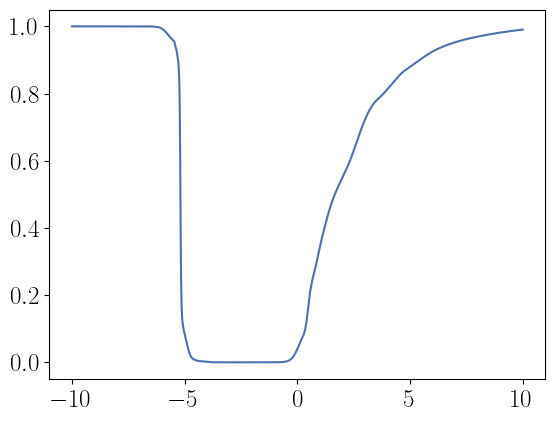

In [22]:
plt.plot(X[:,2], cdf);plt.show()
y = st.chi2.cdf(X[:,2], 2)
plt.plot(X[:,2],y)

In [23]:
def generate(theta, nu, N_points, MLE):
    N = st.poisson.rvs(theta+nu, size=N_points)
    M = st.poisson.rvs(nu, size=N_points)
    lambda_D = lambda_test_2d(N, M, theta, nu, MLE).flatten()
    
    return lambda_D

In [24]:
lambda_list_nonMLE= generate(theta=10, nu=5, N_points=10000, MLE=False)
print('mean=', lambda_list_nonMLE.mean())
print('max=', lambda_list_nonMLE.max())
print('min=', lambda_list_nonMLE.min())

mean= 2.087180852250546
max= 17.004511217510142
min= -0.0


In [25]:
lambda_list_MLE= generate(theta=10, nu=5, N_points=10000, MLE=True)
print('mean=', lambda_list_MLE.mean())
print('max=', lambda_list_MLE.max())
print('min=', lambda_list_MLE.min())

mean= 2.068921484266085
max= 19.843220794391325
min= -0.0


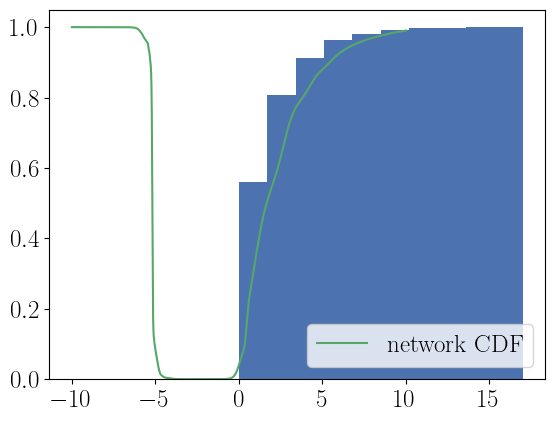

In [27]:

plt.hist(lambda_list_nonMLE, density=True, cumulative=True)
plt.plot(X[:,2], cdf, label = 'network CDF')
# x = np.arange(0, 10, 0.2)
# y = st.chi2.cdf(X[:,2], 2)
# plt.plot(X[:,2],y, label=r'$\chi^2_2$')
plt.legend()
plt.show()

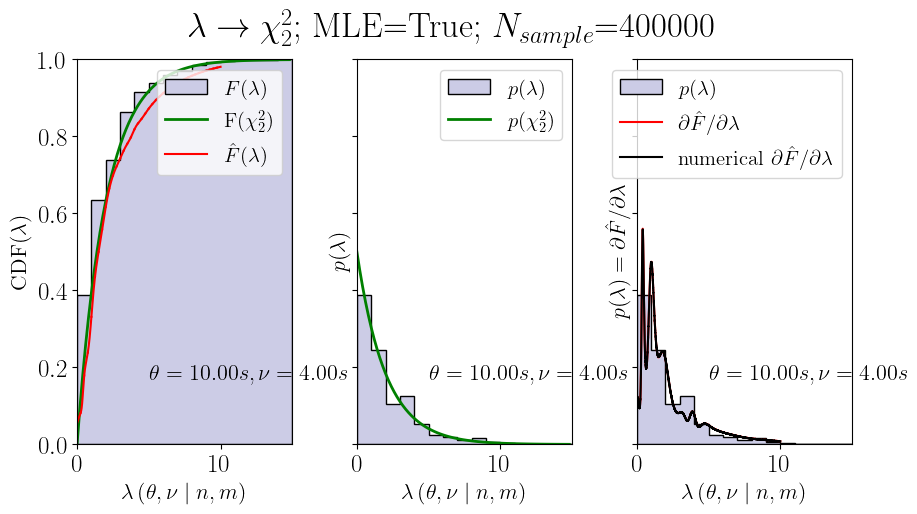

In [269]:
#points=(theta,nu)
chi2_exp_size=400000

points_1 = (10, 4)

MLE=True
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5), sharey=True)

plt.subplots_adjust(wspace=0.3)
# plot_one(lambda_1, points_1[0], points_1[1], ax)
plot_all(lambda_1, points_1[0], points_1[1], ax, MLE=MLE)

fig.suptitle(r'$\lambda \rightarrow \chi^2_2$; MLE=%s; $N_{sample}$=%s' % \
             (  str(MLE), str(int(chi2_exp_size))), fontsize=25); 

ax[1].set_ylabel('$p(\lambda)$')

plt.show()
SAVE=False
if SAVE:
    plt.savefig('images/Wilk_agreement_MLE_%s_N_%s.png' % (str(MLE), str(chi2_exp_size) ))

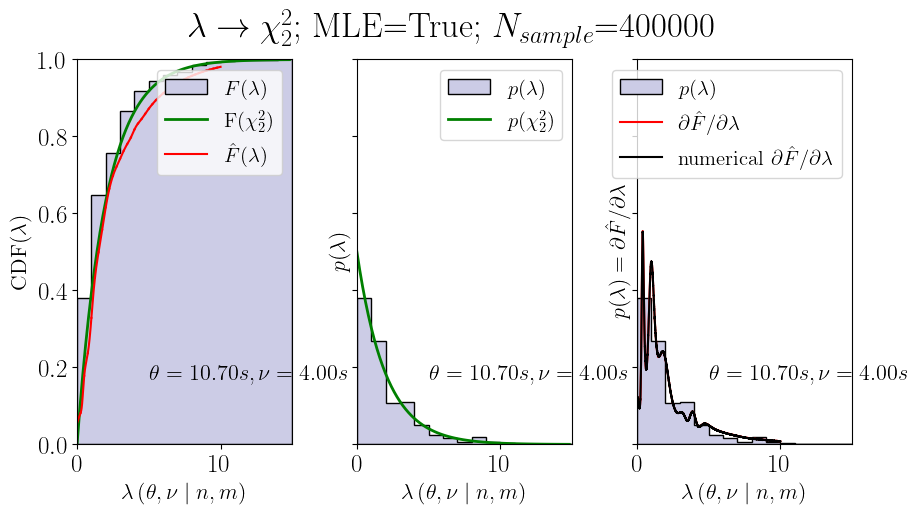

In [270]:
#points=(theta,nu)
chi2_exp_size=400000

points_1 = (10.7, 4)

MLE=True
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5), sharey=True)

plt.subplots_adjust(wspace=0.3)
# plot_one(lambda_1, points_1[0], points_1[1], ax)
plot_all(lambda_1, points_1[0], points_1[1], ax, MLE=MLE)

fig.suptitle(r'$\lambda \rightarrow \chi^2_2$; MLE=%s; $N_{sample}$=%s' % \
             (  str(MLE), str(int(chi2_exp_size))), fontsize=25); 

ax[1].set_ylabel('$p(\lambda)$')

plt.show()
SAVE=False
if SAVE:
    plt.savefig('images/Wilk_agreement_MLE_%s_N_%s.png' % (str(MLE), str(chi2_exp_size) ))

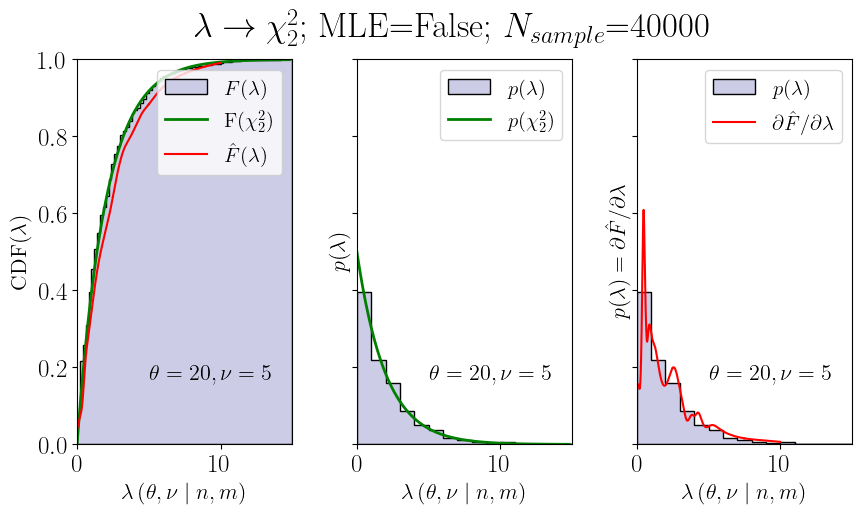

In [119]:
#points=(theta,nu)
chi2_exp_size=40000

points_1 = (20, 5)

MLE=False
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5), sharey=True)

plt.subplots_adjust(wspace=0.3)
# plot_one(lambda_1, points_1[0], points_1[1], ax)
plot_all(lambda_1, points_1[0], points_1[1], ax, MLE=False)

fig.suptitle(r'$\lambda \rightarrow \chi^2_2$; MLE=%s; $N_{sample}$=%s' % \
             (  str(MLE), str(int(chi2_exp_size))), fontsize=25); 

ax[1].set_ylabel('$p(\lambda)$')

plt.show()
SAVE=False
if SAVE:
    plt.savefig('images/Wilk_agreement_MLE_%s_N_%s.png' % (str(MLE), str(chi2_exp_size) ))

In [114]:
thetaMin, thetaMax =  0, 20
numin, numax = 0, 20
Nmin, Nmax =  1,10
Mmin, Mmax =  1 , 10

def generate_training_data_2d(Bprime, MLE, save_data=False):
    """Generate the training data, that is, features=[theta, nu, N, M], targets=Z"""
    #sample theta and nu from uniform(0,20)
    theta = st.uniform.rvs(thetaMin, thetaMax, size=Bprime)
    # nu = st.uniform.rvs(nuMin, nuMax, size=Bprime)
    nu= st.uniform.rvs(numin, numax, size=Bprime)
    #n,m ~ F_{\theta,\nu}, ie our simulator. sample n from a Poisson with mean theta+nu 
    n = st.poisson.rvs(theta+ nu, size=Bprime)
    #sample m from a poisson with mean nu
    m = st.poisson.rvs(nu, size=Bprime)
    #sample our observed counts (N,M), which take the place of D
    N = np.random.randint(Nmin, Nmax, size=Bprime)
    M = np.random.randint(Mmin, Mmax, size=Bprime)
    theta_hat_ = theta_hat_func(N,M, MLE)
    SUBSAMPLE=10
    print('n=', n[:SUBSAMPLE])
    print('m=', m[:SUBSAMPLE])
    print('N=', N[:SUBSAMPLE])
    print('M=', M[:SUBSAMPLE])
    lambda_gen = lambda_test_2d(n, m, theta, nu, MLE)
    print('lambda_gen= ', lambda_gen[:SUBSAMPLE])
    lambda_D = lambda_test_2d(N, M, theta, nu, MLE)
    
    print('lambda_D= ', lambda_D[:SUBSAMPLE])
    #if lambda_gen <= lambda_D: Z=1, else Z=0
    Z = (lambda_gen <= lambda_D).astype(np.int32)
    
    data_2_param = {'theta' : theta, 
                    'nu': nu, 
                   # 'lambda_D': lambda_D,
                   'lambda_gen': lambda_gen
                   }

    data_2_param = pd.DataFrame.from_dict(data_2_param)
    PATH = os.path.join(os.getcwd(), 
                        'data',
                        'TWO_PARAMETERS_WITH_LAMBDA_D_theta_%s_%s_%sk_Examples_MLE_%s.csv' % (str(thetaMin), str(thetaMax), str(int(Bprime/1000)), str(MLE)) )
    if save_data:
        data_2_param.to_csv(PATH)

    print('\n')
    print(data_2_param.describe())
    return data_2_param.to_numpy()

In [115]:
valid_x_nonMLE = generate_training_data_2d(Bprime=100000, MLE=False, save_data=False)
valid_x_nonMLE

n= [15 38 11 11 14 25 39  1 21  3]
m= [ 8 15  5  0 17  3 23  0 27  1]
N= [7 9 5 8 1 8 8 1 8 8]
M= [1 3 8 8 1 5 3 7 1 9]
lambda_gen=  [ 2.69427655  0.72953202  0.45483086  0.72131221 10.41208004  0.9602119
  0.63468687  4.54827958  1.85139681  0.05166791]
lambda_D=  [24.71907972 37.51626115  7.51453853 37.09275913 25.28934495 10.65447884
 55.7714546  37.09879106 42.95259692 26.80709654]


               theta             nu     lambda_gen
count  100000.000000  100000.000000  100000.000000
mean       10.024584       9.988496       1.979485
std         5.770561       5.764529       1.967357
min         0.000076       0.000099       0.000033
25%         5.035627       5.002247       0.576196
50%        10.030915       9.967278       1.381557
75%        15.043905      15.006695       2.743134
max        19.999508      19.999873      29.181308


array([[ 0.94622347, 13.56077159,  2.69427655],
       [19.54413178, 13.78617066,  0.72953202],
       [ 7.56436867,  3.6448864 ,  0.45483086],
       ...,
       [ 0.05380015,  0.04900878,  2.85340151],
       [ 4.58770124, 15.87056777,  0.86167856],
       [12.9931012 , 11.00548164,  3.06551842]])

In [116]:
valid_x_MLE = generate_training_data_2d(Bprime=100000, MLE=True, save_data=False)
valid_x_MLE

n= [11  3 26 25 21 23  7 12 28 24]
m= [ 0  1 10 28  9 11 10  1  8 20]
N= [2 3 4 4 4 4 7 8 5 8]
M= [8 6 8 8 7 7 1 6 4 5]
lambda_gen=  [8.19291487e+00 1.11129551e+00 1.04146309e+00 3.21469291e+00
 5.91364493e-01 9.46930493e-02 7.04486355e-01 4.45241767e-01
 6.74358461e-04 7.86534461e-01]
lambda_D=  [39.45502667 24.57190258 35.00682305 35.49270281 20.84814404 26.87910321
 10.35200584  8.51274523 31.2515742  25.33492118]


               theta             nu     lambda_gen
count  100000.000000  100000.000000  100000.000000
mean        9.995870      10.021628       2.046066
std         5.793001       5.781577       2.030884
min         0.000256       0.000004       0.000028
25%         4.973559       5.023734       0.596596
50%        10.009574      10.035853       1.429262
75%        15.016212      15.025541       2.831899
max        19.999952      19.999501      26.265804


array([[18.40473734,  1.64861625,  8.19291487],
       [ 3.32262789,  0.30241672,  1.11129551],
       [14.79829753, 13.27558984,  1.04146309],
       ...,
       [10.20899622, 11.87704889,  0.92246616],
       [19.44851004,  3.08073249,  1.08419337],
       [18.17277415,  8.48658634,  0.81677833]])

In [194]:
X

array([[2.00000000e+01, 5.00000000e+00, 0.00000000e+00],
       [2.00000000e+01, 5.00000000e+00, 1.00010001e-03],
       [2.00000000e+01, 5.00000000e+00, 2.00020002e-03],
       ...,
       [2.00000000e+01, 5.00000000e+00, 9.99799980e+00],
       [2.00000000e+01, 5.00000000e+00, 9.99899990e+00],
       [2.00000000e+01, 5.00000000e+00, 1.00000000e+01]])

In [201]:
tmodel = TrainedModel(trained_SiLU_model_nonMLE)
pdf = tmodel.pdf(X)

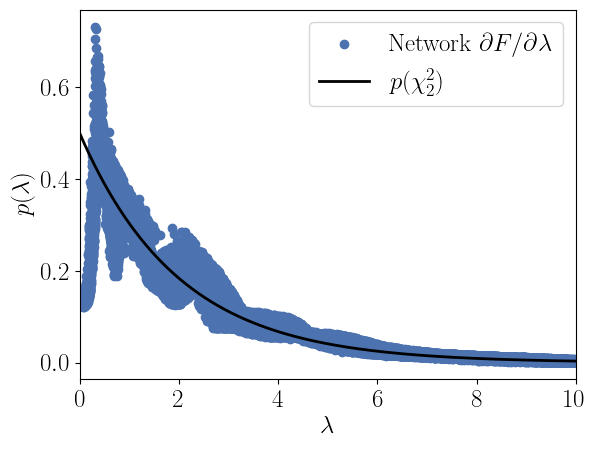

In [74]:
plt.scatter(valid_x_nonMLE[:,-1], pdf, label=r'Network $\partial F / \partial \lambda$')
x = np.linspace(0,10,10000)
plt.plot(x, st.chi2.pdf(x,2), label=r'$p(\chi^2_2)$', color='black', linewidth=2);
plt.xlabel(r'$\lambda$');plt.ylabel(r'$p(\lambda)$')
plt.xlim((0,10))
plt.legend()
plt.show()

In [241]:
def generate_X(theta, nu, N_points, MLE):
    N = st.poisson.rvs(theta+nu, size=N_points)
    M = st.poisson.rvs(nu, size=N_points)
    lambda_D = lambda_test_2d(N, M, theta, nu, MLE)#.flatten()
    X = np.empty((N_points, 3))
    X[:,0] = np.ones_like(theta)*theta
    X[:,1] = np.ones_like(nu)*nu
    X[:,2]  = lambda_D
    return X

In [244]:
X = generate_X(theta=20, nu=5, N_points=1000, MLE=True)

In [247]:
X

array([[20.        ,  5.        ,  0.8750573 ],
       [20.        ,  5.        ,  3.27413048],
       [20.        ,  5.        ,  1.89538972],
       ...,
       [20.        ,  5.        ,  4.9370204 ],
       [20.        ,  5.        ,  2.17385359],
       [20.        ,  5.        ,  0.37074781]])

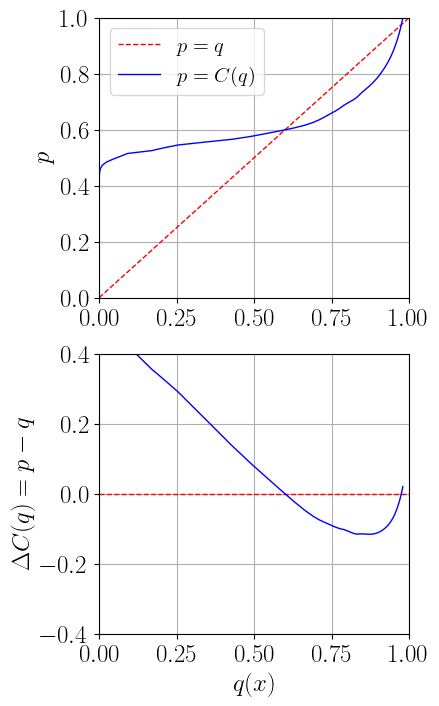

In [223]:
def plot_cc(q, p, ftsize=18):

    xmin, xmax = 0, 1
    ymin, ymax = 0, 1
    
    # create an empty figure
    fig = plt.figure(figsize=(4, 8))
    fig.tight_layout()
    
    # add subplots to it
    nrows, ncols = 2,1
    ax1 = fig.add_subplot(nrows, ncols, 1)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    ax1.set_ylabel('$p$', fontsize=ftsize)
    
    ax2 = fig.add_subplot(nrows, ncols, 2)
    dp  = 0.4
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(-dp, dp)
    ax2.set_xlabel('$q(x)$', fontsize=ftsize)
    ax2.set_ylabel('$\Delta C(q) = p - q$', fontsize=ftsize)
    
    ax1.plot([0, 1], [0, 1], 'r', 
             linewidth=1, 
             linestyle='dashed', 
             label='$p = q$')
    ax1.plot(q, p, 'b', linewidth=1, 
             label='$p = C(q)$')
    ax1.grid(True, which="both", linestyle='-')
    ax1.legend(fontsize='15')
    
    ax2.plot([0, 1], [0, 0], 'r', linewidth=1, linestyle='dashed')
    ax2.plot(q, p-q, 'b', linewidth=1)
    ax2.grid(True, which="both", linestyle='-')

    plt.show()

    
tmodel = TrainedModel(trained_SiLU_model_MLE)
a = tmodel.cdf(X)

p = np.linspace(0,1,100)
q = np.quantile(a,p)
plot_cc(q, p)

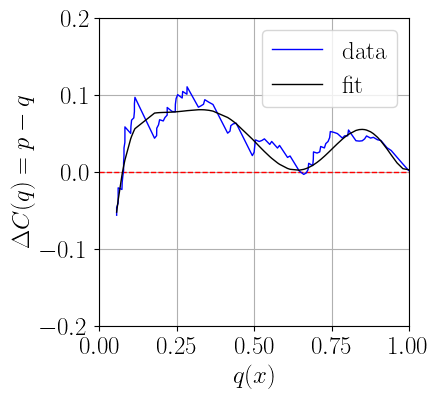

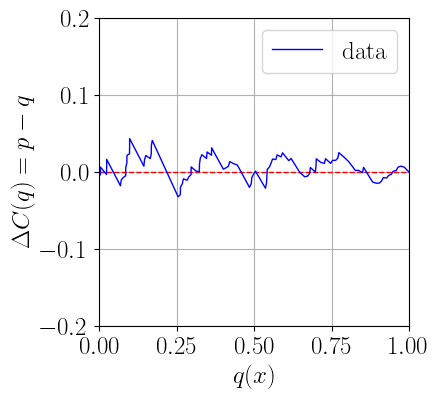

In [224]:
import scipy.optimize as op

def poly(X, A):
    y  = A[0]
    x  = np.ones_like(X)
    for a in A[1:]:
        
        x *= X
        y += a * x
    return y

# 1st derivative of polynomials
def dpoly(X, A):
    y  = 0.0
    x  = np.ones(len(X))
    n  = 1
    for a in A:
        x *= X
        n += 1
        y += n * a * x
    return y

def plot_dc(q, p, res=None, ftsize=18):
    
    dp = 0.2
    xmin, xmax = 0, 1
    ymin, ymax =-dp, dp
    
    # create an empty figure
    fig = plt.figure(figsize=(4, 4))
    fig.tight_layout()
    
    # add subplots to it
    nrows, ncols = 1,1
    ax = fig.add_subplot(nrows, ncols, 1)
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('$q(x)$', fontsize=ftsize)
    ax.set_ylabel('$\Delta C(q) = p - q$', fontsize=ftsize)
    
    ax.plot([0, 1], [0, 0], 'r', linewidth=1, linestyle='dashed')
    ax.plot(q, p-q, 'b', linewidth=1, label='data')

    if res != None:
        y = poly(q, res.x)
        ax.plot(q, y,   'k', linewidth=1, label='fit')
    ax.grid(True, which="both", linestyle='-')
    ax.legend()
    plt.show()
    
    
    
def nll(pars, *args):
    x, y = args
    w = 1/abs(y)
    F = w*(y - poly(x, pars))**2
    return F.sum()

guess  = np.array([1.]*8)
results= op.minimize(nll, guess, args=(q, p-q))

plot_dc(q, p, results)

# plot residuals of corrected cdf
Q = q + poly(q, results.x)
plot_dc(Q, p)

# plot corrected pdf

In [212]:
def plot_pdf(x, y1, y2, ftsize=18):

    xmin, xmax = x[0], x[-1]
    ymin, ymax = 0, 0.5
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows, ncols, index)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.plot(x, y1, 'b', lw=2, label='approx')
    ax.plot(x, y2, 'r', lw=1, linestyle='dashed', label='exact')
    
    ax.set_xlabel('$x$', fontsize=ftsize)
    ax.set_ylabel('$f(x) = \partial F(x) / \partial x$', fontsize=ftsize)
    
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper left')

    plt.show()

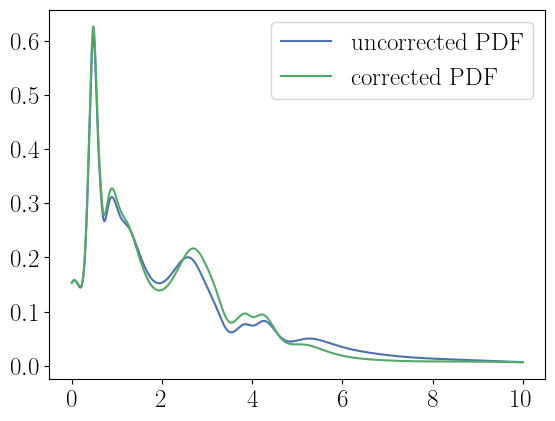

In [213]:
tmodel = TrainedModel(trained_SiLU_model_nonMLE)

N=10000
theta, nu = 20, 5
X = np.empty((N, 3))
X[:,0] = np.ones_like(theta)*theta
X[:,1] = np.ones_like(nu)*nu
X[:,2] = np.linspace(0,10,N)

q = tmodel.cdf(X)
f = tmodel.pdf(X)
f1 = (1 + dpoly(q, results.x)) * f

plt.plot(X[:,-1], f, label='uncorrected PDF')
plt.plot(X[:,-1], f1, label='corrected PDF')
plt.legend()
plt.show()